## CS5488 Project - Price Prediction on Cryptocurrencies
### Project Group 5
<!--
Poon Bing-chun
Jia Shuyue
Li Ka-faat
Tso Yiu-chuen
-->

#### Objective
In this project, we attempt to predict the prices of cryptocurrencies using multiple historical features, by training a deep neural network in a distributed manner across several nodes.

Distributed training is a collection of techniques for using multiple processors located on different machines for training machine learning models. It is an increasingly important deep learning technique, since it enables the training of wider neural networks which is too cumbersome to manage on one machine only.

#### Overview
The [**Horovod** library](https://github.com/horovod/horovod) ([paper](https://towardsdatascience.com/paper-summary-horovod-fast-and-easy-distributed-deep-learning-in-tensorflow-5be535c748d1)) will be used, and the workers will be grouped by an [**Apache Spark** cluster](https://horovod.readthedocs.io/en/stable/spark_include.html) (which will be covered in the last few weeks of the lecture). Horovod distributes training batches to machines for training, averages the gradients of gradient descents, and aggregates the validation metrics returned by each machine. It supports common deep learning frameworks like **Keras**, **TensorFlow** and **PyTorch**.

We will compare the convergence rates with and without distributed training using TensorBoard.

In [1]:
# Import required libraries

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from time import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

#### Data Collection

We have written a Python script [**downloadData_5m.py**](https://github.com/verybighub/CS5488_Project/blob/main/downloadData_5m.py) to collect historical cryptocurrency finance data from [https://coinmarketcap.com/](https://coinmarketcap.com/) using the `Selenium` (for JavaScript to load) and `BeautifulSoup` (for getting data from the right DOM node using CSS selectors) Python libraries. The date range is 1st January, 2019 to 22nd September, 2021 (i.e. the day we collected the data). We have parsed the data into the machine-readable `pandas` `DataFrame` format and placed it in Google Drive.

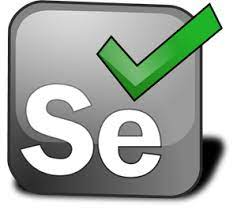 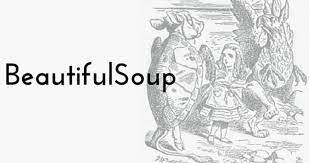

'''
Download historical cryptocurrency market data to CSV format
'''

from time import sleep
from urllib.request import urlopen as u
from re import sub, findall

from bs4 import BeautifulSoup as b
import pandas as pd
from selenium import webdriver

def getData():
    df = pd.DataFrame(columns=('Currency', 'Date', 'Open', 'High', 'Low', 'Close', 'Value', 'Market Cap'))

    # Loop
    options = webdriver.ChromeOptions()
    options.add_argument("--headless")

    driver = webdriver.Chrome(options=options)

    driver.get('https://coinmarketcap.com/coins/')
    for x in range(20):
        driver.execute_script(f'window.scrollTo(0, {x*500})')
        sleep(1)
    soup=b(driver.page_source,'html.parser')

    coins = soup.select('#__next > div.bywovg-1.sXmSU > div.main-content > div.sc-57oli2-0.comDeo.cmc-body-wrapper > div > div:nth-child(1) > div.h7vnx2-1.bFzXgL > table > tbody > tr > td:nth-child(3) > div > a > div > div > p')
    currencies = [x.text for x in coins]
    print(currencies)


    for currency in currencies:
        driver.get(f'https://coinmarketcap.com/currencies/{currency.replace(" ","-").lower()}/historical-data/')
        driver.execute_script('window.scrollTo(0, 1000)')
        sleep(1)
        try:
            for _ in range(50):
                driver.execute_script("document.querySelector('#__next > div > div.main-content > div.sc-57oli2-0.comDeo.cmc-body-wrapper > div > div.sc-16r8icm-0.jKrmxw.container > div > div > p:nth-child(3) > button').click()")
                sleep(2)
        except:
            pass
        soup=b(driver.page_source,'html.parser')
        coins = soup.select('#__next > div > div.main-content > div.sc-57oli2-0.comDeo.cmc-body-wrapper > div > div.sc-16r8icm-0.jKrmxw.container > div > div > div.b4d71h-2.hgYnhQ > table > tbody > tr')
        rows = [x.findChildren('td') for x in coins]
        for row in rows:
            myrow = [cell.text for cell in row]
            myrow[0] = pd.to_datetime(myrow[0])
            for x in range(1, len(myrow)):
                myrow[x] = float(myrow[x].replace('$','').replace(',',''))
            df.loc[len(df)] = [currency, *myrow]
            # print([cell.text for cell in row])  
        print(df)

    driver.quit()
    del driver

    df.to_json('historical_coin_data.json')
    df.to_csv('historical_coin_data.csv')

if __name__ == '__main__':
    getData()

from requests import Session

def download_from_google_drive(id):
    URL = "https://docs.google.com/uc?export=download"

    session = Session()

    response = session.get(URL, params = {'id': id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = {'id': id, 'confirm': token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response):
    CHUNK_SIZE = 32768

    with open('historical_coin_data_5m.json', "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

download_from_google_drive('1gkXRtX1BfeC3uxYb6WxGTn2fN5U8S1OZ')

#### Speed comparison - Load data to DataFrame
PySpark is nearly twice faster than vanilla Python.

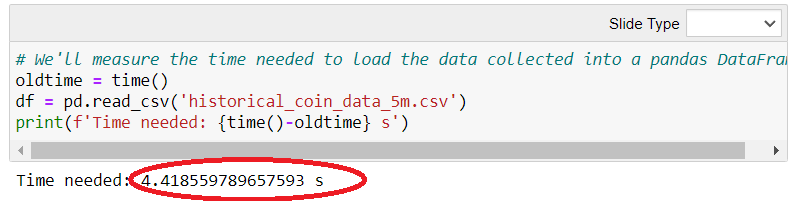
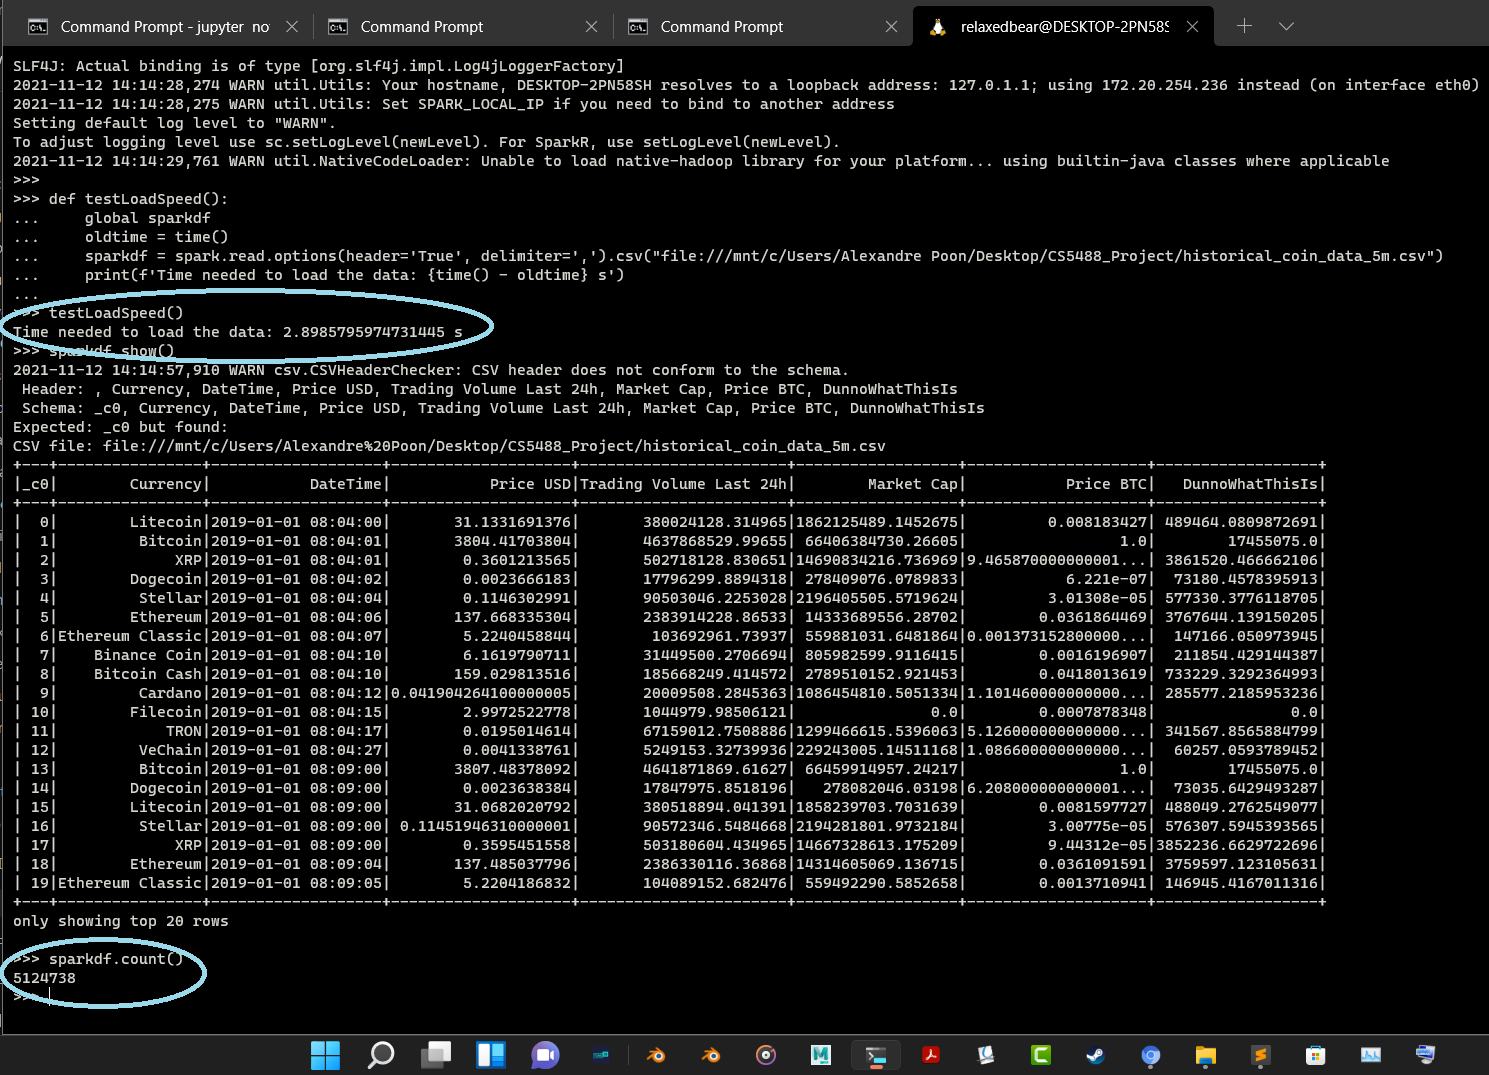

In [2]:
# We'll measure the time needed to load the data collected into a pandas DataFrame
oldtime = time()
df = pd.read_csv('historical_coin_data_5m.csv')
print(f'Time needed: {time()-oldtime} s')

Time needed: 4.248026371002197 s


### Speed comparison - Filtering
Again, PySpark is nearly twice faster than vanilla Python.

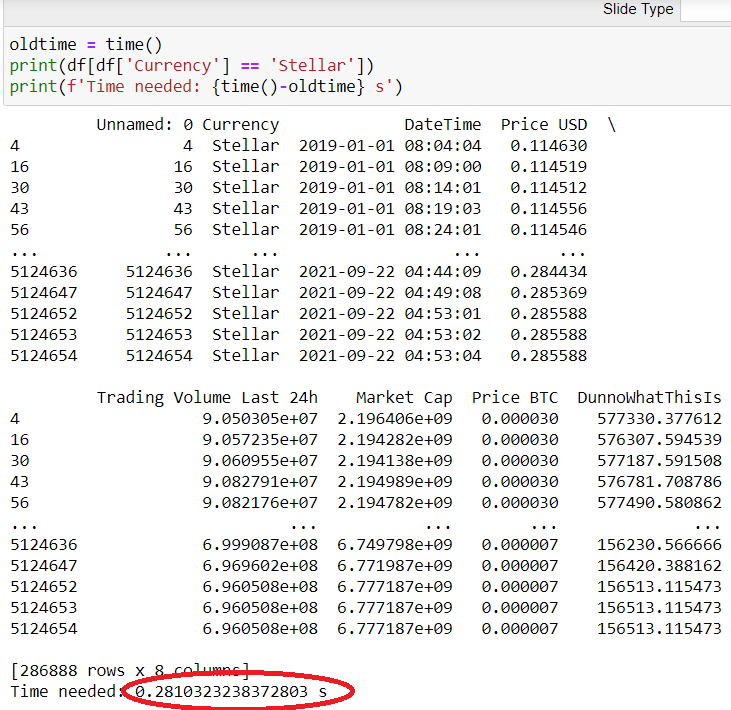
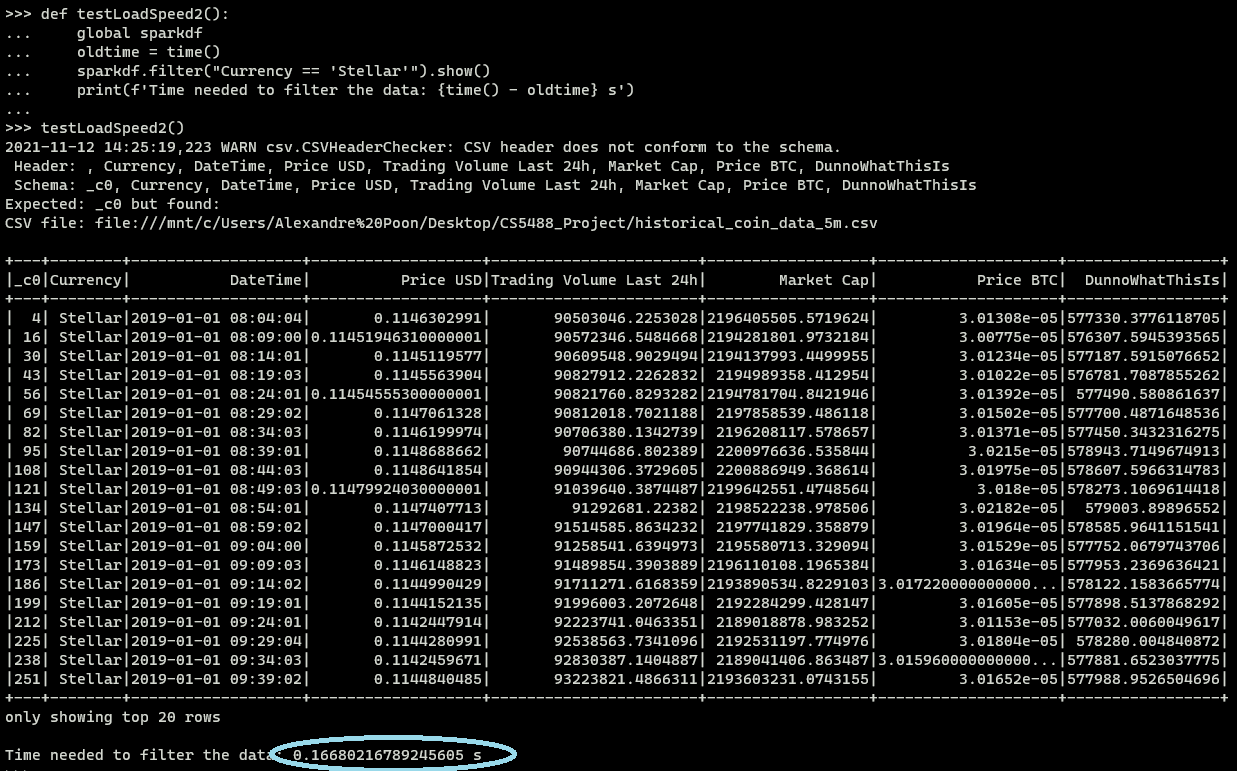

In [93]:
oldtime = time()
print(df[df['Currency'] == 'Stellar'])
print(f'Time needed: {time()-oldtime} s')

         Unnamed: 0 Currency             DateTime  Price USD  \
4                 4  Stellar  2019-01-01 08:04:04   0.114630   
16               16  Stellar  2019-01-01 08:09:00   0.114519   
30               30  Stellar  2019-01-01 08:14:01   0.114512   
43               43  Stellar  2019-01-01 08:19:03   0.114556   
56               56  Stellar  2019-01-01 08:24:01   0.114546   
...             ...      ...                  ...        ...   
5124636     5124636  Stellar  2021-09-22 04:44:09   0.284434   
5124647     5124647  Stellar  2021-09-22 04:49:08   0.285369   
5124652     5124652  Stellar  2021-09-22 04:53:01   0.285588   
5124653     5124653  Stellar  2021-09-22 04:53:02   0.285588   
5124654     5124654  Stellar  2021-09-22 04:53:04   0.285588   

         Trading Volume Last 24h    Market Cap  Price BTC  DunnoWhatThisIs  
4                   9.050305e+07  2.196406e+09   0.000030    577330.377612  
16                  9.057235e+07  2.194282e+09   0.000030    576307.594539  


The raw data is originally in a 5-minute interval. We extract hourly data by skipping intermediate values using the special syntax:

`
df[df['Currency'] == currency]['Price USD'][::12]
`

In [5]:
oldtime = time()
print(df[df['Currency'] == 'Stellar'][::12])
print(f'Time needed: {time()-oldtime} s')

         Unnamed: 0 Currency             DateTime  Price USD  \
4                 4  Stellar  2019-01-01 08:04:04   0.114630   
159             159  Stellar  2019-01-01 09:04:00   0.114587   
316             316  Stellar  2019-01-01 10:04:03   0.114447   
472             472  Stellar  2019-01-01 11:04:02   0.115167   
628             628  Stellar  2019-01-01 12:04:00   0.113171   
...             ...      ...                  ...        ...   
5123877     5123877  Stellar  2021-09-22 00:49:11   0.286183   
5124103     5124103  Stellar  2021-09-22 01:49:07   0.283262   
5124322     5124322  Stellar  2021-09-22 02:49:09   0.285074   
5124502     5124502  Stellar  2021-09-22 03:49:10   0.284622   
5124647     5124647  Stellar  2021-09-22 04:49:08   0.285369   

         Trading Volume Last 24h    Market Cap  Price BTC  DunnoWhatThisIs  
4                   9.050305e+07  2.196406e+09   0.000030    577330.377612  
159                 9.125854e+07  2.195581e+09   0.000030    577752.067974  


In [3]:
df

,Currency,DateTime,Price USD,Trading Volume Last 24h,Market Cap,Price BTC,DunnoWhatThisIs
0,Litecoin,2019-01-01 08:04:00,31.133169,3.800241e+08,1.862125e+09,8.183427e-03,4.894641e+05
1,Bitcoin,2019-01-01 08:04:01,3804.417038,4.637869e+09,6.640638e+10,1.000000e+00,1.745508e+07
2,XRP,2019-01-01 08:04:01,0.360121,5.027181e+08,1.469083e+10,9.465870e-05,3.861520e+06
3,Dogecoin,2019-01-01 08:04:02,0.002367,1.779630e+07,2.784091e+08,6.221000e-07,7.318046e+04
4,Stellar,2019-01-01 08:04:04,0.114630,9.050305e+07,2.196406e+09,3.013080e-05,5.773304e+05
...,...,...,...,...,...,...,...
5124733,Internet Computer,2021-09-22 05:49:10,48.568079,3.332303e+08,7.911265e+09,1.121945e-03,1.827539e+05
5124734,Internet Computer,2021-09-22 05:49:12,48.568079,3.332303e+08,7.911265e+09,1.121945e-03,1.827539e+05
5124735,VeChain,2021-09-22 05:54:14,0.096595,5.599202e+08,6.212570e+09,2.231800e-06,1.435412e+05
5124736,VeChain,2021-09-22 05:54:16,0.096595,5.599202e+08,6.212570e+09,2.231800e-06,1.435412e+05


In [3]:
# Choose a currency
currency = 'Stellar'

# Originally the data has a 5-minute interval
# We can use Python to get hourly interval using this syntax: [::12] because 60 / 5 = 12
# Skip every 12 values
price = df[df['Currency'] == currency]['Price USD'][::12]
vol =  df[df['Currency'] == currency]['Trading Volume Last 24h'][::12]
marketcap =  df[df['Currency'] == currency]['Market Cap'][::12]
datetime =  df[df['Currency'] == currency]['DateTime'][::12]

### Limitations of PySpark
In vanilla Python, we can easily do `list[::12]` to skip certain values.
Yet, in Spark, there is **no "every nth row" function**.


Skipping rows is still achievable by the following but way slower:

`
import pyspark.sql.functions as F
from pyspark.sql import Window
def testLoadSpeed3():
	global sparkdf
	oldtime = time()
	w = Window().orderBy(F.lit("_c0"))
	sparkdf.filter("Currency == 'Stellar'").withColumn("id", F.row_number().over(w)).filter("id % 12 == 1").show()
	print(f'Time needed to filter the data: {time() - oldtime} s')
`


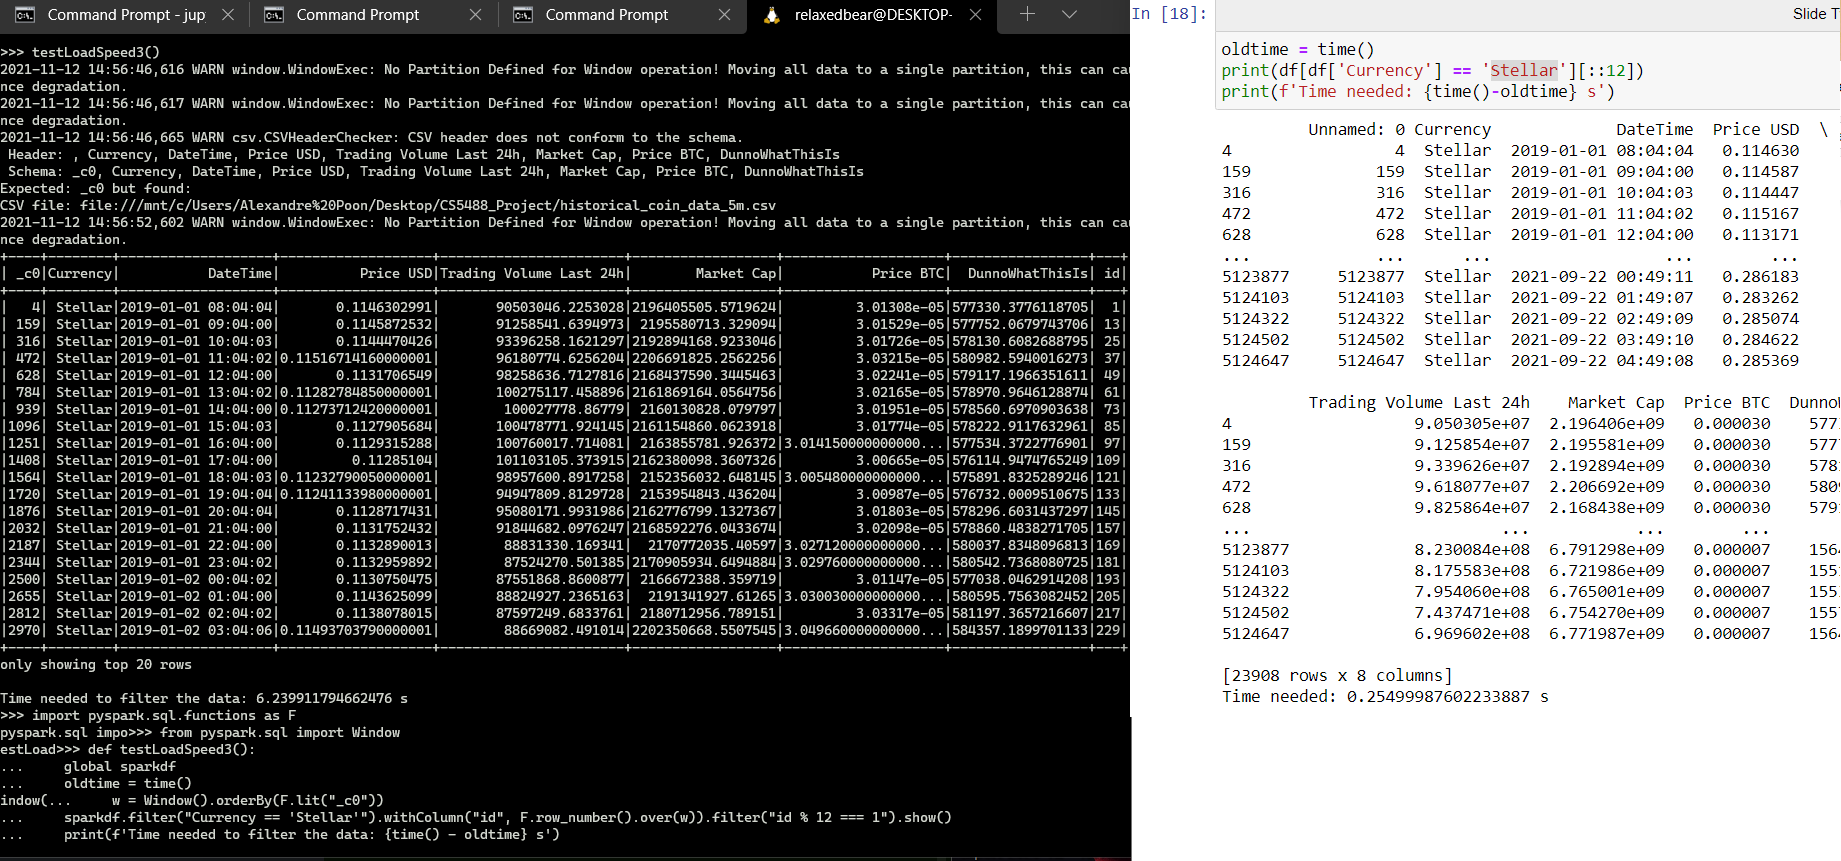

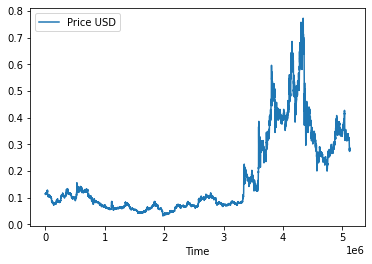

In [111]:
plt.plot(price, label='Price USD')
plt.xlabel('Time')
plt.legend()

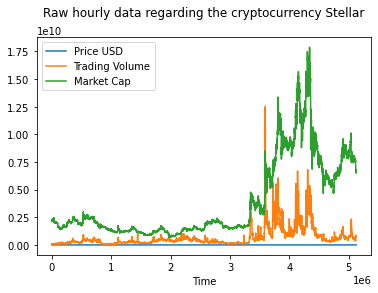

In [23]:
plt.title(f'Raw hourly data regarding the cryptocurrency {currency}\n')
plt.plot(price, label='Price USD')
plt.plot(vol, label='Trading Volume')
plt.plot(marketcap, label='Market Cap')
ticks = datetime[::100]
#plt.xticks(ticks)
plt.xlabel('Time')
plt.legend()

From the above chart, the number range seems to be exponentially rising to a large number (as large as 1e10). As a result, we will use the log scale (transform by: `log(f(x)  + 1)`) to remove the skew. [1]

* [1] Ciaburro, G. (2018). 7. Stock Volatility Forecasting Using Long Short-Term Memory. In Keras 2.x projects: 9 projects demonstrating faster experimentation of neural network and ... Deep Learning applications using Keras (pp. 223–224). essay, PACKT Publishing Limited.

In [4]:
# From the above chart, the number range seems to be exponentially rising to a large number (as large as 1e10), so we will use the log scale instead.
feats=np.dstack([np.log(price[1:] + 1),np.log(vol[1:] + 1),np.log(marketcap[1:] + 1)])[0,:,:]

print(feats.shape)

(23907, 3)


#  Data scaling

Note that we are using LSTM, **NOT** an ARIMA model. We don't have to remove the trend, sesonality, and cyclicity from the data. Yet, we still need to process the data by data scaling.

* Robust scaler: Helps removing outliers
* Min-max normalisation: Scale all features between 0-1: model performs better when numerical input variables are scaled to a standard range

In [5]:
# Data scaling
# Robust scaler: Helps removing outliers
scaler = RobustScaler()
# Min-max normalisation: Scale all features between 0-1: model performs better when numerical input variables are scaled to a standard range
scaler2 = MinMaxScaler()

feats_scaled = scaler2.fit_transform(scaler.fit_transform(feats))
print(feats_scaled)

[[0.14211855 0.11708727 0.3672111 ]
 [0.14188603 0.12124256 0.36684163]
 [0.1430799  0.12651471 0.36873441]
 ...
 [0.40518686 0.50564134 0.70679707]
 [0.40453634 0.49359046 0.70631799]
 [0.40561021 0.48193059 0.70710853]]


In [6]:
# Compared to unscaled below, which has a much larger range -> many data points appears as outliers
feats

array([[ 0.10848416, 18.32920716, 21.50971241],
       [ 0.10835836, 18.35236185, 21.50848805],
       [ 0.1090043 , 18.38174006, 21.51476032],
       ...,
       [ 0.2508166 , 20.49436319, 22.63502831],
       [ 0.25046464, 20.42721158, 22.63344073],
       [ 0.25104566, 20.36223881, 22.63606042]])

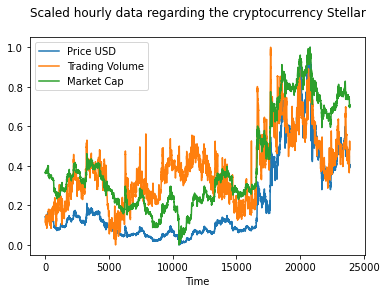

In [10]:
# Plot scaled features
plt.title(f'Scaled hourly data regarding the cryptocurrency {currency}\n')
plt.xlabel('Time')
plt.plot(feats_scaled,label=('Price USD','Trading Volume','Market Cap'))
plt.legend()

Then, we make sliding windows from the scaled data.
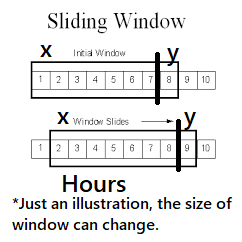

In [7]:
# size: 35 => training data isfeatures from last 35 hours
sliding_window = np.lib.stride_tricks.sliding_window_view(feats_scaled, (35 + 3 ,3), axis=(0,1))
sliding_window = sliding_window.reshape((sliding_window.shape[0], sliding_window.shape[2], sliding_window.shape[3]))

# Xs: Price, volume, market cap and price of the past week
Xs = np.array([i[:-3] for i in sliding_window])
# Xs: Price of the next three hours
Ys = np.array([i[-3:,0] for i in sliding_window])

print('-----------------------\nXs:\n')
print(Xs)
print('-----------------------\nYs:\n')
print(Ys)
print('-----------------------\nXs:\n')
print(Xs.shape)
print('-----------------------\nYs:\n')
print(Ys.shape)

-----------------------
Xs:

[[[0.14211855 0.11708727 0.3672111 ]
  [0.14188603 0.12124256 0.36684163]
  [0.1430799  0.12651471 0.36873441]
  ...
  [0.14473905 0.11869073 0.3713566 ]
  [0.14469951 0.11600263 0.37129457]
  [0.14517726 0.11634764 0.37204334]]

 [[0.14188603 0.12124256 0.36684163]
  [0.1430799  0.12651471 0.36873441]
  [0.13976798 0.13035038 0.36345719]
  ...
  [0.14469951 0.11600263 0.37129457]
  [0.14517726 0.11634764 0.37204334]
  [0.14483455 0.10062515 0.37150637]]

 [[0.1430799  0.12651471 0.36873441]
  [0.13976798 0.13035038 0.36345719]
  [0.13919871 0.13399596 0.36254171]
  ...
  [0.14517726 0.11634764 0.37204334]
  [0.14483455 0.10062515 0.37150637]
  [0.14445257 0.1041338  0.37090689]]

 ...

 [[0.45203777 0.3657207  0.73984305]
  [0.44435679 0.37352423 0.73461181]
  [0.44647332 0.37718095 0.7360602 ]
  ...
  [0.39486206 0.51207059 0.69912238]
  [0.40029538 0.51482557 0.70318008]
  [0.40265334 0.5118771  0.70492789]]

 [[0.44435679 0.37352423 0.73461181]
  [0.446

# Data splitting

We first bifurcate Train+Validation VS Test, then divide Train from Validation by choosing evenly distributed random chunks using `StratifiedShuffleSplit`.

We **do not** outright chop into three pieces, because doing such will make all recent features fall into the validation set instead of the training set. Such data splitting scheme enables the model to learn recent features.

The split percentages are 80% for training, 10% for validation, and 10% for test.

<!--
`
splits = get_splits(y, valid_size=.2, stratify=True, random_state=23, shuffle=True)
splits
` -->

<!-- ![image.png](attachment:image.png)
 -->
<!-- Reference: https://colab.research.google.com/github/timeseriesAI/tsai/blob/master/tutorial_nbs/00c_Time_Series_data_preparation.ipynb#scrollTo=207JZDz657T4 -->

In [8]:
from sklearn.model_selection import StratifiedShuffleSplit as SSS
    
TrainAndValLen = int(len(Xs) * 0.90)

classNum = 12

sizeOfClass = TrainAndValLen // classNum
remainder = TrainAndValLen % classNum

classes = []

for i in range(classNum):
    classes += [i] * sizeOfClass
classes += [i] * remainder

print(classes)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [9]:
rs = SSS(n_splits=1, test_size=0.1111)
for train_index, val_index in rs.split(Xs[0:TrainAndValLen,:], classes):
    print("TRAIN:", train_index)
    print("VALIDATION:", val_index)


x_train = Xs[0:TrainAndValLen,:][train_index]
y_train = Ys[0:TrainAndValLen][train_index]

x_val = Xs[0:TrainAndValLen,:][val_index]
y_val = Ys[0:TrainAndValLen,:][val_index]

x_test = Xs[TrainAndValLen:,:]
y_test = Ys[TrainAndValLen:]

y_train = y_train.reshape((y_train.shape[0],y_train.shape[1],1))
y_val = y_val.reshape((y_val.shape[0],y_val.shape[1],1))
y_test = y_test.reshape((y_test.shape[0],y_test.shape[1],1))

TRAIN: [ 8902 14745 12380 ...  5348 19638  3314]
VALIDATION: [12210 13085  4838 ... 11078   329 20022]


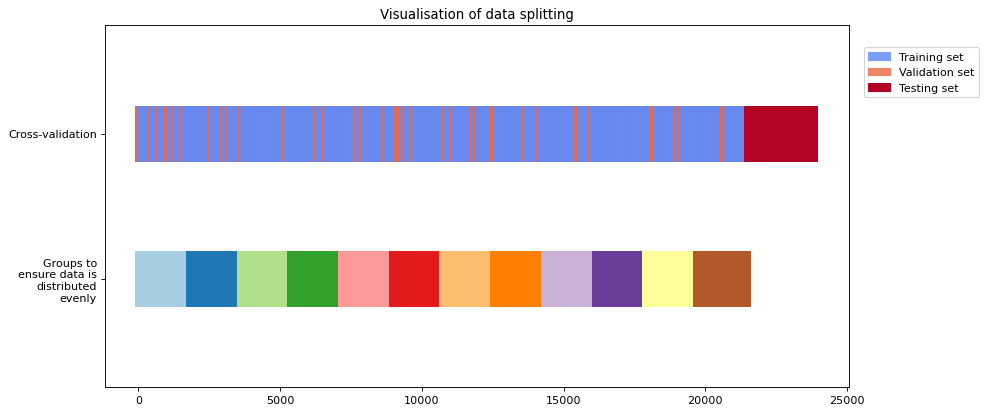

In [14]:
# Visualise
from matplotlib.patches import Patch
fig, ax = plt.subplots(figsize=(12, 6), dpi=80)

z = [1] * len(classes)
z += [2] * (len(Xs) - len(classes))
z = np.array(z)
z[train_index] = 0

ax.scatter(range(len(z)),[0.7]*len(z),marker="_",c=z,
        lw=50, label='Train', cmap=plt.cm.coolwarm,  vmin=-0.2,
            vmax=1.2)

ax.scatter(range(len(classes)),[0.3]*len(classes),marker="_",c=classes,
        lw=50, cmap=plt.cm.Paired)
ax.set(
        ylim=[0, 1],
        yticks=[0.3, 0.7],
    yticklabels=["Groups to\nensure data is\ndistributed\nevenly", "Cross-validation"],
)
plt.title('Visualisation of data splitting')
ax.legend(
        [Patch(color=plt.cm.coolwarm(0.2)), Patch(color=plt.cm.coolwarm(0.8)), Patch(color=plt.cm.coolwarm(2.0))],
        ["Training set", "Validation set", "Testing set"],
        loc=(1.02, 0.8),
    )

In [240]:
np.savez('x_train',x_train)
np.savez('x_val',x_val)
np.savez('x_test',x_test)

np.savez('y_train',y_train)
np.savez('y_val',y_val)
np.savez('y_test',y_test)

In [241]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(19096, 35, 3)
(2387, 35, 3)
(2387, 35, 3)
(19096, 3, 1)
(2387, 3, 1)
(2387, 3, 1)


# Model selection

LSTM. We choose Adam: because higher learning rate.
The stopping criterion is that the loss of the validation set does not decrease after 10 epochs (`patience=10`). The reason of patience is that the validation loss fluctuates a lot: there is quite a lot of noise.

### LSTM

In [262]:
model = Sequential()
model.add(LSTM(128, dropout=0.05, return_sequences=True))
# Stacking LSTM hidden layers makes the model deeper.
model.add(LSTM(64, dropout=0.05))
model.add(Dense(3, activation='sigmoid'))

# Adam optimiser allows high learning rate at first and speeds up training
model.compile(optimizer='nadam', loss='mean_squared_error', metrics=['mean_squared_error'])

# Early stop to prevent overfitting
callbackEs = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, verbose=1, restore_best_weights=True)

# Log performance using TensorBoard
callbackTb = tf.keras.callbacks.TensorBoard()

model.fit(x_train, y_train, shuffle=True, epochs=500, verbose=2, validation_data=(x_val, y_val), callbacks = [callbackTb, callbackEs])

Epoch 1/500
597/597 - 25s - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 3.0541e-04 - val_mean_squared_error: 3.0541e-04
Epoch 2/500
597/597 - 17s - loss: 5.4354e-04 - mean_squared_error: 5.4354e-04 - val_loss: 3.1773e-04 - val_mean_squared_error: 3.1773e-04
Epoch 3/500
597/597 - 17s - loss: 4.1868e-04 - mean_squared_error: 4.1868e-04 - val_loss: 1.8591e-04 - val_mean_squared_error: 1.8591e-04
Epoch 4/500
597/597 - 17s - loss: 3.8162e-04 - mean_squared_error: 3.8162e-04 - val_loss: 2.1851e-04 - val_mean_squared_error: 2.1851e-04
Epoch 5/500
597/597 - 18s - loss: 3.6369e-04 - mean_squared_error: 3.6369e-04 - val_loss: 1.7836e-04 - val_mean_squared_error: 1.7836e-04
Epoch 6/500
597/597 - 18s - loss: 3.5127e-04 - mean_squared_error: 3.5127e-04 - val_loss: 2.4065e-04 - val_mean_squared_error: 2.4065e-04
Epoch 7/500
597/597 - 18s - loss: 3.4611e-04 - mean_squared_error: 3.4611e-04 - val_loss: 1.6979e-04 - val_mean_squared_error: 1.6979e-04
Epoch 8/500
597/597 - 17s - loss: 3.4256e-

### Alternative model: MLP (multi-layer perceptron)

In [19]:
# MLP
model = Sequential()
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(3, activation='sigmoid'))

# Adam optimiser allows high learning rate at first and speeds up training
model.compile(optimizer='nadam', loss='mean_squared_error', metrics=['mean_squared_error'])

# Early stop to prevent overfitting
callbackEs = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, verbose=1, restore_best_weights=True)

# Log performance using TensorBoard
callbackTb = tf.keras.callbacks.TensorBoard()

model.fit(x_train.reshape((x_train.shape[0],x_train.shape[1]*x_train.shape[2])), y_train.reshape((y_train.shape[0],y_train.shape[1])), shuffle=True, epochs=500, verbose=2, validation_data=(x_val.reshape((x_val.shape[0],x_train.shape[1]*x_val.shape[2])), y_val.reshape((y_val.shape[0],y_val.shape[1]))), callbacks = [callbackTb, callbackEs])

Epoch 1/500
597/597 - 1s - loss: 0.0072 - mean_squared_error: 0.0072 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 2/500
597/597 - 0s - loss: 8.2209e-04 - mean_squared_error: 8.2209e-04 - val_loss: 3.5803e-04 - val_mean_squared_error: 3.5803e-04
Epoch 3/500
597/597 - 0s - loss: 6.0732e-04 - mean_squared_error: 6.0732e-04 - val_loss: 1.9994e-04 - val_mean_squared_error: 1.9994e-04
Epoch 4/500
597/597 - 0s - loss: 5.0517e-04 - mean_squared_error: 5.0517e-04 - val_loss: 1.5527e-04 - val_mean_squared_error: 1.5527e-04
Epoch 5/500
597/597 - 0s - loss: 4.6673e-04 - mean_squared_error: 4.6673e-04 - val_loss: 1.4918e-04 - val_mean_squared_error: 1.4918e-04
Epoch 6/500
597/597 - 0s - loss: 4.0588e-04 - mean_squared_error: 4.0588e-04 - val_loss: 1.3551e-04 - val_mean_squared_error: 1.3551e-04
Epoch 7/500
597/597 - 0s - loss: 3.7744e-04 - mean_squared_error: 3.7744e-04 - val_loss: 2.8874e-04 - val_mean_squared_error: 2.8874e-04
Epoch 8/500
597/597 - 0s - loss: 3.6095e-04 - mean_square

In [ ]:
model = Sequential()
model.add(Dense(128, dropout=0.05, return_sequences=True))
# Stacking LSTM hidden layers makes the model deeper.
model.add(LSTM(64, dropout=0.05))
model.add(Dense(3, activation='sigmoid'))

# Adam optimiser allows high learning rate at first and speeds up training
model.compile(optimizer='nadam', loss='mean_squared_error', metrics=['mean_squared_error'])

# Early stop to prevent overfitting
callbackEs = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, verbose=1, restore_best_weights=True)

# Log performance using TensorBoard
callbackTb = tf.keras.callbacks.TensorBoard()

model.fit(x_train, y_train, shuffle=True, epochs=500, verbose=2, validation_data=(x_val, y_val), callbacks = [callbackTb, callbackEs])

In [263]:
i = model.predict(x_test)
predicted = np.ravel(i)

print(i)
print(y_test)

print(i.shape)
print(y_val.shape)
'''
for x_test:
    model.predict()
'''

[[0.50157565 0.49976218 0.5021006 ]
 [0.50162077 0.4998018  0.5021385 ]
 [0.501941   0.50012624 0.5024622 ]
 ...
 [0.40314555 0.4041468  0.40349302]
 [0.40253    0.4035189  0.40284252]
 [0.40201652 0.4029528  0.4022705 ]]
[[[0.48404594]
  [0.49019795]
  [0.48800549]]

 [[0.49019795]
  [0.48800549]
  [0.4869798 ]]

 [[0.48800549]
  [0.4869798 ]
  [0.48719233]]

 ...

 [[0.40677995]
  [0.40257796]
  [0.40518686]]

 [[0.40257796]
  [0.40518686]
  [0.40453634]]

 [[0.40518686]
  [0.40453634]
  [0.40561021]]]
(2387, 3)
(2387, 3, 1)


'\nfor x_test:\n    model.predict()\n'

# Evaluation
The metric used is root mean square error.
## LSTM

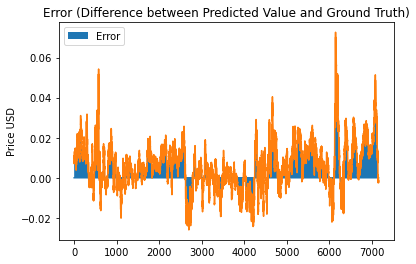

In [264]:
predicted2 = np.ravel(i)
y_test2 = np.ravel(y_test)

plt.title('Error (Difference between Predicted Value and Ground Truth)')
# Apply inverse transform to cancel the effects of MinMax scaler and Robust scaler to get back the original
error = np.exp(scaler.inverse_transform(scaler2.inverse_transform([[x,0,0] for x in predicted2]))[:,0]) - np.exp(scaler.inverse_transform(scaler2.inverse_transform([[x,0,0] for x in y_test2]))[:, 0])
plt.plot(np.arange(len(error)), [0] * len(error))
plt.plot(error)
plt.fill_between(np.arange(len(error)), [0] * len(error), error, label='Error')
plt.ylabel('Price USD')
plt.legend()

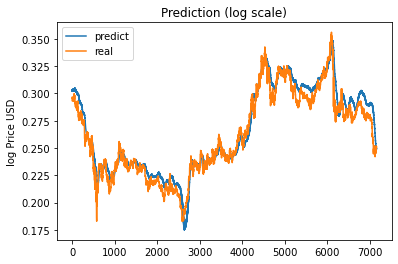

In [265]:
predicted3 = scaler.inverse_transform(scaler2.inverse_transform([[x,0,0] for x in predicted2]))[:,0].ravel()
y_test3 = scaler.inverse_transform(scaler2.inverse_transform([[x,0,0] for x in y_test2]))[:,0].ravel()

plt.title('Prediction (log scale)')
plt.ylabel('log Price USD')
plt.plot(predicted3,label="predict")
plt.plot(y_test3,label="real")
plt.legend()

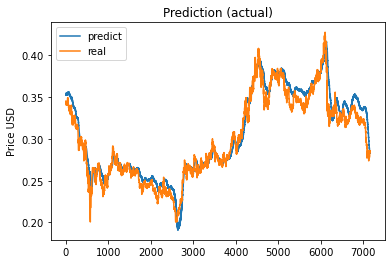

In [267]:
# Undo the log to see the actual price in USD
predicted0 = np.exp(predicted3)-1
y_test0 = np.exp(y_test3)-1

plt.title('Prediction (actual)')
plt.ylabel('Price USD')
plt.plot(predicted0,label="predict")
plt.plot(y_test0,label="real")
plt.legend()

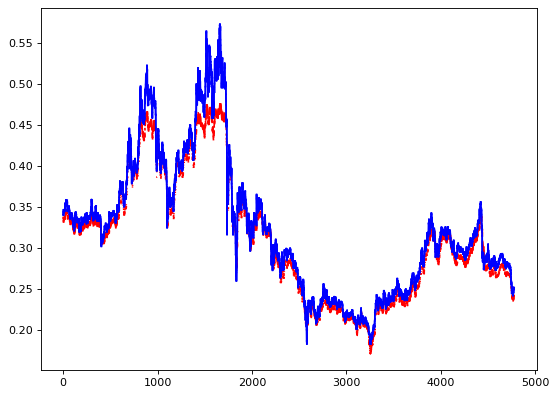

In [96]:
i3 = scaler.inverse_transform(scaler2.inverse_transform([[x,0,0] for x in predicted2]))[:,0].reshape(i.shape)
y_test3 = scaler.inverse_transform(scaler2.inverse_transform([[x,0,0] for x in y_test2]))[:,0].reshape(y_test.shape)

from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)
for x in range(len(i3)):
    plt.plot(np.arange(x,x+3), i3[x],'r--',label="predict")
for x1 in range(len(y_test)):
    plt.plot(np.arange(x1,x1+3), y_test3[x1],'b-',label="real")
#plt.legend()

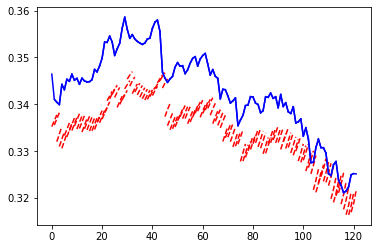

In [98]:
for x in range(0,120):
    plt.plot(np.arange(x,x+3), i3[x],'r--',label="predict")
    plt.plot(np.arange(x,x+3), y_test3[x],'b-',label="real")

#  Alternative Model 1: MLP

[[0.47688195 0.47477332 0.4765929 ]
 [0.4768365  0.47502834 0.47669747]
 [0.4782258  0.47638255 0.47800446]
 ...
 [0.41248748 0.41304076 0.41514745]
 [0.41116962 0.41201574 0.41420585]
 [0.4108457  0.41179696 0.41393003]]
[[[0.48404594]
  [0.49019795]
  [0.48800549]]

 [[0.49019795]
  [0.48800549]
  [0.4869798 ]]

 [[0.48800549]
  [0.4869798 ]
  [0.48719233]]

 ...

 [[0.40677995]
  [0.40257796]
  [0.40518686]]

 [[0.40257796]
  [0.40518686]
  [0.40453634]]

 [[0.40518686]
  [0.40453634]
  [0.40561021]]]
(2387, 3)
(2387, 3, 1)


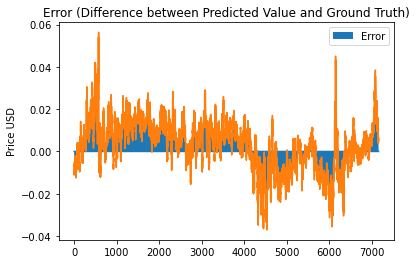

In [23]:
i = model.predict(x_test.reshape((x_test.shape[0],x_test.shape[1]*x_test.shape[2])))
predicted = np.ravel(i)

print(i)
print(y_test)

print(i.shape)
print(y_val.shape)
'''
for x_test:
    model.predict()
'''


predicted2 = np.ravel(i)
y_test2 = np.ravel(y_test)

plt.title('Error (Difference between Predicted Value and Ground Truth)')
# Apply inverse transform to cancel the effects of MinMax scaler and Robust scaler to get back the original
error = np.exp(scaler.inverse_transform(scaler2.inverse_transform([[x,0,0] for x in predicted2]))[:,0]) - np.exp(scaler.inverse_transform(scaler2.inverse_transform([[x,0,0] for x in y_test2]))[:, 0])
plt.plot(np.arange(len(error)), [0] * len(error))
plt.plot(error)
plt.fill_between(np.arange(len(error)), [0] * len(error), error, label='Error')
plt.ylabel('Price USD')
plt.legend()

In [22]:
print(f'Root mean square error (RMSE): ${np.sqrt(np.mean(error ** 2))}')
print(f'Mean absolute error (MAE): ${np.mean(error)}')

Root mean square error (RMSE): $0.0112678006302128343
Mean absolute error (MAE): $0.0028758278519440887



# Alternative Model 2: RandomForestRegressor (Prediction by Regression)

These alternative models perform worse than using neural networks.

For RandomForestRegressor, we use 3-fold cross validation to find the optimal hyperparameters.

`n_jobs=-1` in the RandomForestRegressor means to use all cores, which is multiprocessing (NOT multithreading).

In [10]:
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import GridSearchCV

In [20]:
paramsampler = {
	'n_estimators'      : np.linspace(200,1000,5).astype(int),
	'max_depth'         : np.linspace(10,100,5).astype(int),
	'max_features'      : ['auto'],#'sqrt','log2'],
	'random_state'      : [0],
	'min_samples_split' : [1,2,3],
    'min_samples_leaf'  : [1,2,3]
}

In [21]:
regr = GridSearchCV(estimator = RandomForestRegressor(), param_grid = paramsampler, 
                      cv = 3, n_jobs = -1, verbose = 1)

# fit() and predict() are all parallelized over the trees.
# n_jobs=-1 means use all processors.
regr.fit(x_train[:-100].reshape((x_train[:-100].shape[0],x_train[:-100].shape[1]*x_train[:-100].shape[2])),
         y_train[:-100].reshape((y_train[:-100].shape[0],y_train[:-100].shape[1])))

Fitting 3 folds for each of 225 candidates, totalling 675 fits


KeyboardInterrupt: 

In [14]:
# fit() and predict() are all parallelized over the trees.
# n_jobs=-1 means use all processors.
tree = regr.predict(x_val.reshape((x_val.shape[0],x_train.shape[1]*x_val.shape[2])))

NotFittedError: This GridSearchCV instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [32]:
tree = regr.score(x_val.reshape((x_val.shape[0],x_train.shape[1]*x_val.shape[2])),y_val.reshape((y_val.shape[0],y_val.shape[1])))

In [33]:
tree

0.9902697013039568

[[0.43607956 0.43611917 0.436365  ]
 [0.43607956 0.43611917 0.436365  ]
 [0.43607956 0.43611917 0.436365  ]
 ...
 [0.43607956 0.43611917 0.436365  ]
 [0.43607956 0.43611917 0.436365  ]
 [0.43607956 0.43611917 0.436365  ]]
[[[0.48404594]
  [0.49019795]
  [0.48800549]]

 [[0.49019795]
  [0.48800549]
  [0.4869798 ]]

 [[0.48800549]
  [0.4869798 ]
  [0.48719233]]

 ...

 [[0.40677995]
  [0.40257796]
  [0.40518686]]

 [[0.40257796]
  [0.40518686]
  [0.40453634]]

 [[0.40518686]
  [0.40453634]
  [0.40561021]]]
(2387, 3)
(2387, 3, 1)


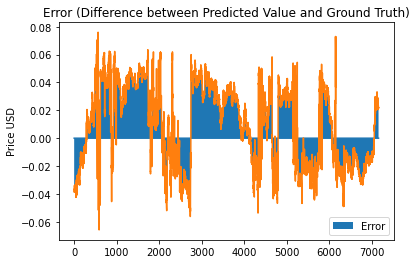

In [34]:
i = regr.predict(x_test.reshape((x_test.shape[0],x_test.shape[1]*x_test.shape[2])))
predicted = np.ravel(i)

print(i)
print(y_test)

print(i.shape)
print(y_val.shape)
'''
for x_test:
    model.predict()
'''


predicted2 = np.ravel(i)
y_test2 = np.ravel(y_test)

plt.title('Error (Difference between Predicted Value and Ground Truth)')
# Apply inverse transform to cancel the effects of MinMax scaler and Robust scaler to get back the original
error = np.exp(scaler.inverse_transform(scaler2.inverse_transform([[x,0,0] for x in predicted2]))[:,0]) - np.exp(scaler.inverse_transform(scaler2.inverse_transform([[x,0,0] for x in y_test2]))[:, 0])
plt.plot(np.arange(len(error)), [0] * len(error))
plt.plot(error)
plt.fill_between(np.arange(len(error)), [0] * len(error), error, label='Error')
plt.ylabel('Price USD')
plt.legend()

# Alternative Model 3: ARIMA

In [11]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

In [12]:
variable = 'Price USD'
currency = 'Stellar'

model = pm.auto_arima(df[df['Currency']==currency][variable][-1000:],
                      start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # no seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-11305.691, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-11309.507, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-11307.892, Time=0.30 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-11307.877, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-11309.737, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.198 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1000
Model:               SARIMAX(0, 1, 0)   Log Likelihood                5655.868
Date:                Tue, 16 Nov 2021   AIC                         -11309.737
Time:                        23:28:54   BIC                         -11304.830
Sample:                             0   HQIC                        -11307.872
                               - 1000                             

In [25]:
variable = 'Price USD'
currency = 'Stellar'

model = pm.auto_arima(np.log(df[df['Currency']==currency][variable][-1000:-100][::12] + 1),trace=True)
'''
start_p=1, start_q=1,
test='adf',       # use adftest to find optimal 'd'
max_p=20, max_q=20, # maximum p and q
m=1,              # frequency of series
d=None,           # let model determine 'd'
seasonal=False,   # no seasonality
start_P=0, 
D=0, 
trace=True,
error_action='ignore',  
suppress_warnings=False, 
stepwise=True)
'''

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-675.540, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-681.316, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-680.070, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-680.288, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-681.022, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-677.315, Time=0.07 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.352 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   75
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 342.658
Date:                Tue, 16 Nov 2021   AIC                           -681.316
Time:                        23:31:19   BIC                           -676.708
Sample:                             0   HQIC                          -679.478
          

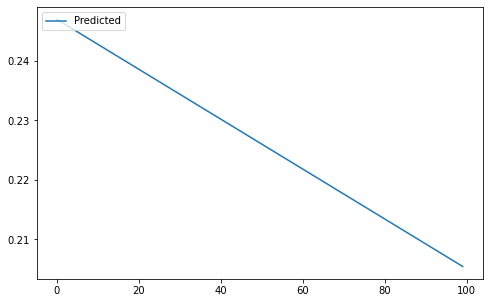

In [26]:
prediction = model.predict(n_periods = 100)
plt.figure(figsize=(8,5))
#plt.plot(np.log(df[df['Currency']==currency][variable][-100:][::12] + 1),label="Training")
plt.plot(prediction,label="Predicted")
plt.legend(loc = 'upper left')
plt.show()

### Alternative Model: Compare model performance with TSForecaster from the tsai library
The library used a similar approach using sliding window for forecast.

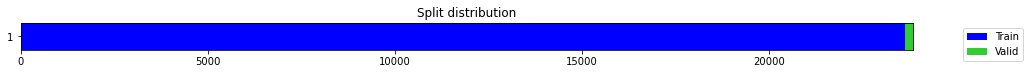

epoch,train_loss,valid_loss,mae,time
0,0.063613,0.012698,0.108020,01:05
1,0.039500,0.001529,0.035375,01:02
2,0.026304,0.008870,0.093707,01:01
3,0.020220,0.005011,0.070334,00:59
4,0.016761,0.008284,0.090554,01:00
5,0.020348,0.000326,0.016647,01:00
6,0.015487,0.003892,0.061790,01:00
7,0.017383,0.004552,0.067231,01:07
8,0.013469,0.001801,0.041981,01:06
9,0.011117,0.000217,0.013521,01:05


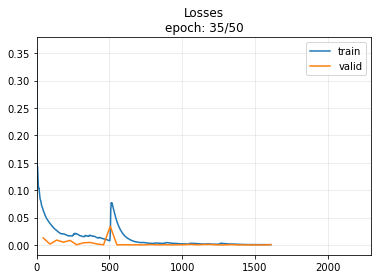

KeyboardInterrupt: 

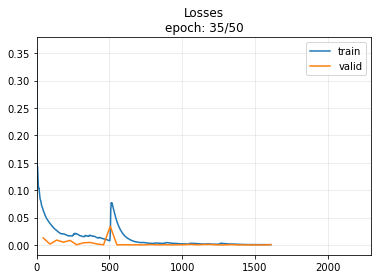

In [26]:
from tsai.all import *
ts = df[df['Currency']==currency][variable][::12]
X, y = SlidingWindow(60, horizon=1)(ts)
splits = TimeSplitter(235)(y) 
batch_tfms = TSStandardize()
fcst = TSForecaster(X, y, splits=splits, batch_tfms=batch_tfms, bs=512, arch=TST, metrics=mae, cbs=ShowGraph())
fcst.fit_one_cycle(50, 1e-3)

In [41]:
np.array(df[df['Currency']==currency][variable][::12][-100:])

array([0.32826621, 0.32164313, 0.32085329, 0.32000876, 0.32076917,
       0.31999362, 0.32195134, 0.32402552, 0.32056747, 0.31821859,
       0.32131653, 0.31924686, 0.31744905, 0.31887406, 0.32003504,
       0.31661604, 0.32095239, 0.32082455, 0.32251496, 0.32506584,
       0.32507221, 0.32644691, 0.32607949, 0.32593968, 0.32543835,
       0.32641506, 0.32575624, 0.32383193, 0.32556268, 0.32543215,
       0.32457241, 0.32333877, 0.32209087, 0.32128421, 0.32097472,
       0.31931816, 0.32104573, 0.32050794, 0.32206873, 0.32003258,
       0.32111853, 0.32257408, 0.32310404, 0.32087645, 0.32226662,
       0.3226098 , 0.32208369, 0.32398582, 0.32377732, 0.32367832,
       0.31627439, 0.31635579, 0.31938747, 0.32062471, 0.31960115,
       0.31886613, 0.31759095, 0.31892   , 0.31686862, 0.31869659,
       0.31806555, 0.31259933, 0.31410331, 0.30748884, 0.30885028,
       0.30171598, 0.29737137, 0.2974368 , 0.2967637 , 0.29571289,
       0.29172069, 0.29387608, 0.29046188, 0.28894427, 0.27706

In [76]:
valid_preds_inc, valid_targets_inc = fcst.get_preds(ds_idx=1)

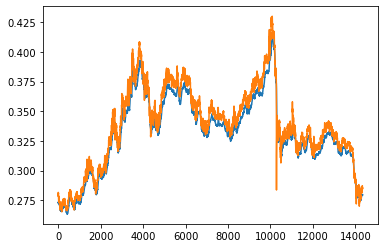

In [77]:
plt.plot(valid_preds_inc.flatten().data)
plt.plot(valid_targets_inc.data)

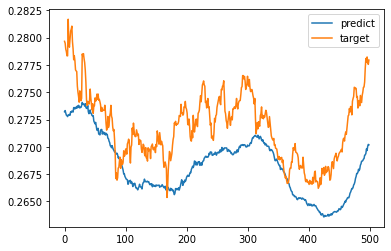

In [84]:
plt.plot(valid_preds_inc.flatten().data[0:500], label='predict')
plt.plot(valid_targets_inc.data[0:500], label='target')
plt.legend()

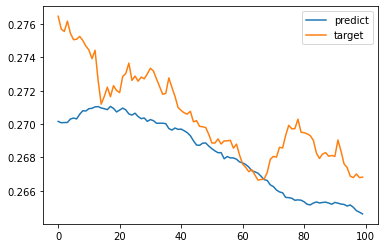

In [82]:
plt.plot(valid_preds_inc.flatten().data[300:400], label='predict')
plt.plot(valid_targets_inc.data[300:400], label='target')
plt.legend()

In [25]:
print(f'Root mean square error (RMSE): ${np.sqrt(np.mean(error ** 2))}')
print(f'Mean absolute error (MAE): ${np.mean(error)}')

Root mean square error (RMSE): $0.0131243821203600876
Mean absolute error (MAE): $0.0028880229058708578


<!-- actually just np.sum(error) 
np.sum(error ** 2)

# Model selection results

| Forecast model | Mean Absolute Error | Average Root Mean Square Error |
| ------------------ | ------------------ | ------------------------- |
| LSTM |  |  |
| MLP |  |  |
| tsai `TSForecaster` |  |  |
| scikit-learn CV RandomForestRegressor |  |  | -->

The performance is very similar to LSTM (LSTM has only slightly smaller errors), which corroborates the notion of using sliding window.

Comparing the root mean square error, we conclude that LSTM is the fittest model for our case.

# Distributed neural network training
## Introducing allreduce

* Gradient descent: A neural network layer is learned by applying gradient descent.
* Backpropagation: Recursively use the gradient of descendant layers. Gradients multiply in each layer.

How neural network works is by train weights using backpropagation algorithm.

Basic idea of distributed learning: Different batches of the dataset is processed by different nodes, and the gradient is passed to the neighbouring node, which have that gradient combined with its own gradient.

**allreduce** is a type of algorithm that combines gradients across different workers. This algorithm aggregates gradient values from different workers by, for example, summing them and then copying them to different workers. Its implementation can be very efficient as it reduces the overhead involved in synchronizing the gradients. Many allreduce algorithm implementations are available, depending on the types of communication available between workers and on the architecture's topology.

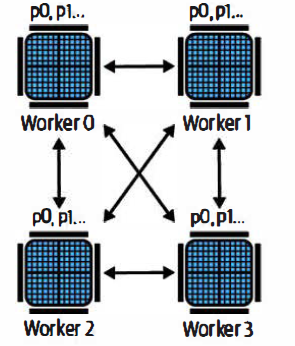

## How ring-allreduce works

Ring-allreduce is the most common implementation of the allreduce algorithm, which is used by the Hovorod library and the`tf.distribute.MirroredStrategy` class provided by TensorFlow. Each worker sends its gradient to its successor on the ring and receives a gradient from its predecessor. **Eventually, each worker receives a copy of the combined gradients.**

### Advantages
Ring-allreduce **uses message passing bandwidth optimally, because it uses both the upload message passing and download  message passing bandwidth of each worker**. It is fast whether working with multiple workers on a single machine (which is our case) or a small number of machines. [2][3]

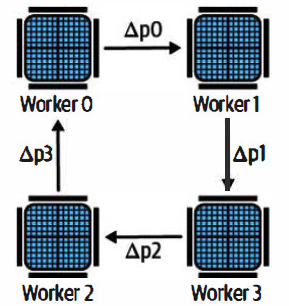

* [2] Tung, K. C. (2021). 8. Distributed Learning. In TensorFlow 2 pocket reference: Building and deploying machine learning models (pp. 156–181). O'Reilly Media, Inc.
* [3] Parker, A., Spoonhower, D., Mace, J., &amp; Sigelman, B. (2020). Distributed tracing in practice instrumenting, analyzing, and debugging microservices. O'Reilly. 

# Conclusion
## Performance comparison
As a control experiment, we keep most settings the same. The difference is with and without multiple workers.
* **Early stop condition**: validation_loss does not decrease for 10 turns
* Model: 2-layered LSTM
* Framework: Keras (w/ and w/o Horovod)
* Optimiser: ADAM
* Operating system: Ubuntu 20.04 LTS on Windows Linux Subsystem
* Processor: Intel(R) Core(TM) i7-10700K CPU @ 3.80GHz
* Memory: 16 GB

According to TensorBoard logs, the LSTM model is about twice faster to converge (faster to reach the Early Stop) with distributed learning than without.

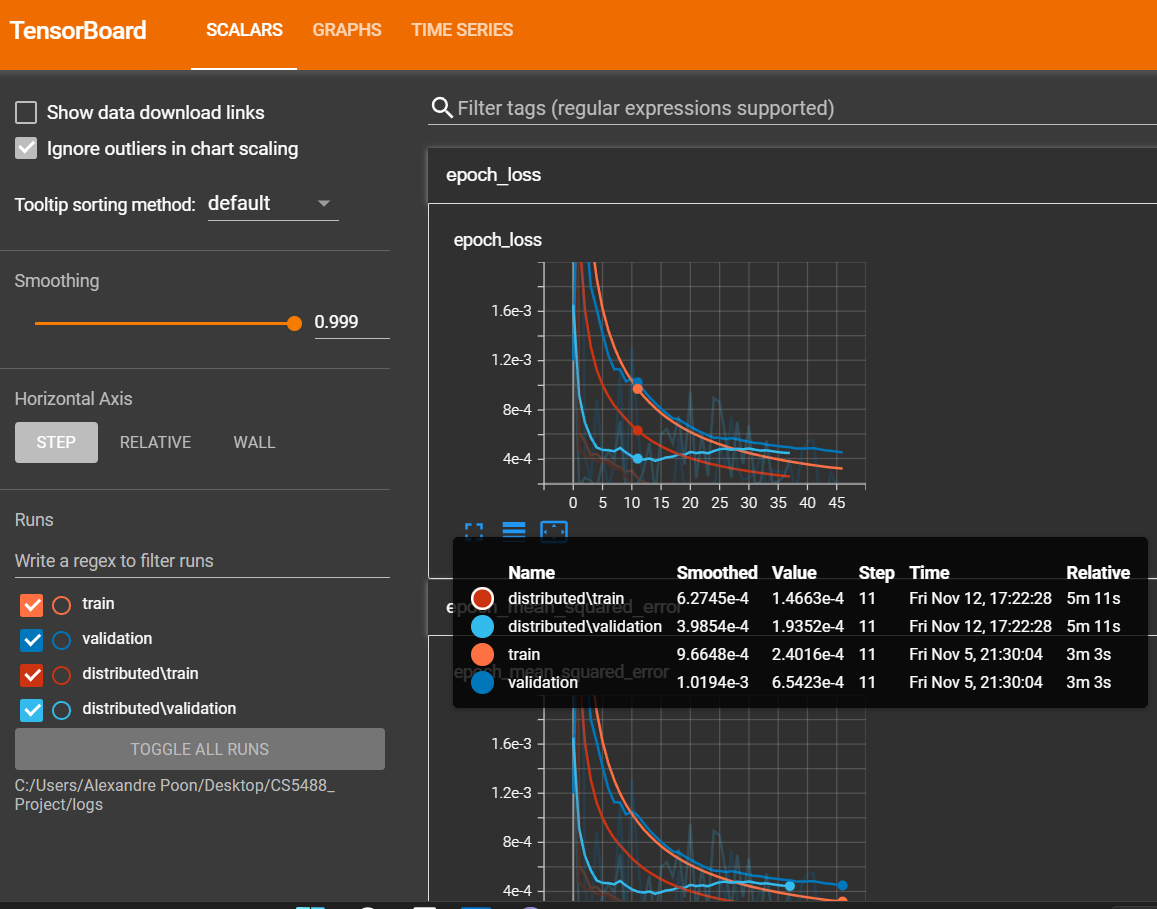